FaceNet is a model developed in 2015 which extracts high quality features from the given image 
and predicts 128 sized vectors called image embeddings.

It's a deep CNN model which is optimized via triplet loss function. Aimed at making vector embeddings for the same identity
to have less distance and larger distances for vestors of different identities.

A notable example is Keras FaceNet by Hiroki Taniai. His project provides a script for converting the Inception ResNet v1 model from TensorFlow to Keras. He also provides a pre-trained Keras model ready for use.

We will use the pre-trained Keras FaceNet model provided by Hiroki Taniai in this tutorial. It was trained on MS-Celeb-1M dataset and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.


It uses YOLO (you only look once) algo. 
There are 3 versions YOLOv1 - general architecture. YOLOv2 - refined and predefined anchor boxes to improve bounding box proposal.
YOLOv3 - Further refined structure and training.

YOLO approach consists of one deep CNN that splits input to grid cells and predcits bounding boxes and detect object. Lots of bounding boxes are predicted so we get rid of insignificant ones using IoU and NMS process. It all happens in one evaluation with faster process often used in live videos.

Since the whole detection pipeline is a single network, it can be optimized end-to-end directly on detection performance.

OVERVIEW 

DarkNet GitHub contains code for all yolo versions.

YAD2K project makes yolov2 code for loading weights and pretrained model and use to predcit object and bounding boxes.

Perhaps the most widely used project for using pre-trained the YOLO models is called “keras-yolo3: Training and Detecting Objects with YOLO3” by Huynh Ngoc Anh or experiencor. The code in the project has been made available under a permissive MIT open source license. Like YAD2K, it provides scripts to both load and use pre-trained YOLO models as well as transfer learning for developing YOLOv3 models on new datasets.

He also has a keras-yolo2 project that provides similar code for YOLOv2 as well as detailed tutorials on how to use the code in the repository. The keras-yolo3 project appears to be an updated version of that project.

He has applied thing mdoel for standard object detection like kangaroo or red bloo dcell prediction.

We will use experiencor’s keras-yolo3 project as the basis for performing object detection with a YOLOv3 model in this tutorial.

## OBJECT Detection with yolov3 keras model

We will load keras yolov3 model, it's weights and perform object detecion on unseen photograph.

First download the weights - It was trained on DarkNet Code base on MSCOCO dataset.

### let's make the model with the same architecture as DarkNet Code Base (loosely made from VGG_16 model) from which we have extracted the weights.
model = make_volov3_model()

### Loding weights
weight_reader = WeightReader('yolov3.weights')

### set the model weights into the model using load_weights() func
weight_reader.load_weights(model)

save the model with keras compatible .H5 file
model.save('model.H5')

In [1]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model, load_model


C:\Users\p192\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\p192\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [ ]:
will create new model using pretrained model.
make_yolov3_model() will create architecture of many conv_blocks comprising of 100 odds layers. 

conv_blocks are formed using different combinations of filters, kernels, padding and striding. Used bias for leaky_relu and no bias if batch_normalization

Also adding skip connections with layer outputs to improve results or reduce overfitting  

After creating 5 blocks of 36 layers - skip_36

After creating 7 blocks of 61 layers - skip_61

upsampled and then concatenate(ll blocks_84 layers, skip_61)
upsampled and then concatenate(l3 blocks_96 layers, skip_36)

[yolo_82, yolo_94, yolo_106]

I used WeightReader class which has load_weights() function to unpack weights using get_weights() and assign them to corresponding layers using set_weights() to the architecture designed using convblocks.

Then will save this new model and read it again to make predictions on new images.


In [2]:
'''
Define convolution blocks and model architecture same as model weights.
'''
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model


class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0


# define the model
model = make_yolov3_model()

# load weights
weight_reader = WeightReader('yolov3.weights')

#Using weights in the model
weight_reader.load_weights(model)

#save the model to file
model.save('model.h5')

C:\Users\p192\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

loading weights of convolution #104
loading weights of convolution #105


Weights from the pretrained models have been loaded and applied to corresponding conv layers and saved again in the current directory.

### making Predictions

In [12]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Load the image original
def image_load(image, shape):
    #load original image
    img = load_img(image)
    width, height = img.size
    
    #reshape image to model size
    img = load_img(image, target_size = shape)
    #to numpy array
    img = img_to_array(img)
    #to float and rescale
    img = img.astype('float32')
    img = img/225
    
    # add a dimension so that we have one sample
    img = expand_dims(img, 0)
    
    return img, width, height

# load_model
model = load_model('model.h5')

# input image
image = 'zebra.jpg'
shape = (416, 416)
img, width, height = image_load(image, shape)

#make_predictions
yhat = model.predict(img)

#shape of the yhat
print([a.shape for a in yhat])
print('\n')
print('Prediction outputs 3 numpy arrays which are shapes of 3 bounding boxes. But also contains the bounding boxes and class labels that needs to be decoded.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


Prediction outputs 3 numpy arrays which are shapes of 3 bounding boxes. But also contains the bounding boxes and class labels that needs to be decoded.


These 3 bounding boxes are are defined in context of anchor boxes, whose size is choosen based on images in the MSCOCO dataset.



In [13]:
# based on https://github.com/experiencor/keras-yolo3

import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

'''
decode_netout() will iterate through these 3 numpy boxes and pull bounding boxes (with prob > 60%) along with their class labels
in the context of the input image shape. It calculates position in the space and class BoundBox predicts score and class and 
saves all these values for 3 boxes and return it.

I think there are two questions here. Firstly, the one in the title, asking where the anchors come from. Secondly, how anchors are assigned to objects. I'll try to answer both.

Anchors are determined by a k-means procedure, looking at all the bounding boxes in your dataset. 
If you're looking at vehicles, the ones you see from the side will have an aspect ratio of about 2:1 (width = 2*height). 
The ones viewed from in front will be roughly square, 1:1. If your dataset includes people, the aspect ratio might be 1:3. 
Foreground objects will be large, background objects will be small. The k-means routine will figure out a selection of anchors 
that represent your dataset. k=5 for yolov3, but there are different numbers of anchors for each YOLO version.
It's useful to have anchors that represent your dataset, because YOLO learns how to make small adjustments to the anchor boxes 
in order to create an accurate bounding box for your object. YOLO can learn small adjustments better/easier than large ones.
'''

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]        # pulled first two numbers as grid height and grid width
    nb_box = 3                               # 3 boxes to consider 
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) 
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2]) # scores geenrated in output are fed to sigmoid to calculate probs
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh  #consider only boxes which has probs > 60% or obj_threshold

    for i in range(grid_h*grid_w):
        '''we iterate through whole grids as rows and columns to find if there is any image present through probs score 
        in any specific grid. And in that we find dimenions image's center position (x,y) and anchor 
        # These dimesnions are fed to BoundBox class to return the class and probs of the bouding boxes that got selected.
        '''
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):                            # to iterate through first box. 
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]  # 5th element in prediction is seen which has prob score
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]  # first 4 has image width, image height, anchor width, anchor height
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]  # last element has classes 
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes) # to return the class and probs
            boxes.append(box)
    return boxes

'''
boxes actually contains size as per model defintion. I translated to original input shape so that these boxes can be applied 
to detect real images.

correct_yolo_boxes() function inputs boxes, model image & original shape  shape and reframe the bounding boxes shape.
'''

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

'''
calculate the intersection over union. That is selecting boxes which covers the major part of the object.
'''
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
'''
Many overlapping boxes are predicted out of which the best one will be selected for an object. 
So used Non max suppression which ignores most significant overlapped boxes > 0.5, but keep bounding boxes < 0.5 as it might predict other objects in
other cases.

Using suppression ratio of 50%.
'''

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

'''
It loads a test image and return refined test image along with original height and width.
'''

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold

'''
It basically iterates through all 3 boxes after appling IoU and NMS. For each box, it checks predicted probability for 
all labels (might predict other object too) and assign the label to it with probability of greather than 60%.

Returned boxes will have 3 bounding boxes with the best predicted class and probability.

Labels are defined in the same way as in the original model trained on MSCOCO dataset.
'''

def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
'''
draw_boxes() takes in original test file which requires prediction. That image gets plotted and x,y labels are extracted 
from the boxes and rectangle is created and plotted to view the bounding boxes around the image objects along with probability. 
'''
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
10647
10647


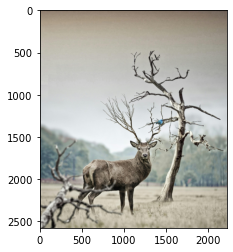

In [67]:
# load yolov3 model
model = load_model('model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416

# define our new photo
#photo_filename = 'zebra.jpg'
photo_filename = 'pexels-pixabay-219906.jpg'


# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# make prediction
yhat = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in yhat])

# define the anchors
#anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)): #3
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
print(len(boxes))   
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)


# suppress non-maximal boxes
do_nms(boxes, 0.5)
print(len(boxes))

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
    
    
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [62]:
v_labels 

['zebra', 'zebra', 'zebra']

In [63]:
v_scores

[99.81460571289062, 93.89262795448303, 96.8082845211029]

In [60]:
len(boxes)

133.0875

In [56]:
v_boxes

In [49]:
len(labels)

80

In [15]:
len(yhat)

3

In [42]:
len(yhat[0][0])

13

In [43]:
netout = yhat[0]
grid_h, grid_w = netout.shape[:2]        # pulled first two numbers as grid height and grid width
 
nb_box = 3                               # 3 boxes to consider 
netout = netout.reshape((grid_h, grid_w, nb_box, -1)) 
nb_class = netout.shape[-1] - 5

In [55]:
netout.classes

AttributeError: 'numpy.ndarray' object has no attribute 'classes'

In [54]:
len(netout)

1

In [44]:
grid_w

13

In [45]:
grid_h

1

In [47]:
nb_class

1100

In [48]:
netout.shape[-1]

1105

In [46]:
netout

array([[[[ 0.4441294 ,  0.66123515,  0.349642  , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.6056709 ,  0.5527229 ,  0.26368245, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.5184089 ,  0.44042307, -0.02468631, ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.4440028 ,  0.48940116, -0.01934844, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.51246035,  0.44223785,  0.38866878, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.39422604,  0.48099983,  0.00302744, ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.33998668,  0.43431708,  0.09454987, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.54451734,  0.4899438 ,  0.25604925, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.4789279 ,  0.56869227, -0.02400136, ...,  0.        ,
           0.        ,  0.        ]],

        ...,

        [[ 0.53069115,  0.6669347 , -0.37335

In [41]:
yhat[0].shape[:2] 

(1, 13)

In [34]:
len(yhat[1][0][0][0])

255

In [36]:
yhat[1][0][0][0]

array([ 5.8820623e-01,  6.5515661e-01, -3.3857125e-01, -3.3997744e-02,
        9.7447889e-07,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      